In [26]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import warnings
from adjustText import adjust_text  # for label adjustment in plots

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
palette = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-darkgrid')

In [27]:
# 1. Load datasets
amazon_prime_titles = pd.read_csv('amazon_prime_titles.csv')
disney_plus_titles = pd.read_csv('disney_plus_titles.csv')
hulu_titles = pd.read_csv('hulu_titles.csv')
netflix_titles = pd.read_csv('netflix_titles.csv')


In [28]:
# 2. Standardize column names and add platform column
def standardize_columns(df, platform_name):
    expected_columns = ['show_id', 'type', 'title', 'director', 'cast', 'country',
                        'date_added', 'release_year', 'rating', 'duration',
                        'listed_in', 'description']
    for col in expected_columns:
        if col not in df.columns:
            df[col] = np.nan
    df['platform'] = platform_name
    return df[expected_columns + ['platform']]

amazon_prime_titles = standardize_columns(amazon_prime_titles, 'Amazon Prime')
disney_plus_titles = standardize_columns(disney_plus_titles, 'Disney+')
hulu_titles = standardize_columns(hulu_titles, 'Hulu')
netflix_titles = standardize_columns(netflix_titles, 'Netflix')


In [29]:
# 3. Clean and process all four datasets
datasets = [amazon_prime_titles, disney_plus_titles, hulu_titles, netflix_titles]

for i in range(len(datasets)):
    df = datasets[i]
    df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    df['director'].fillna('Unknown', inplace=True)
    df['cast'].fillna('Unknown', inplace=True)
    df['country'].fillna('Unknown', inplace=True)
    df['rating'].fillna('Unknown', inplace=True)
    df['duration'].fillna('Unknown', inplace=True)
    df['listed_in'].fillna('Unknown', inplace=True)
    df['description'].fillna('No Description', inplace=True)
    datasets[i] = df  # Save cleaned df back


In [30]:
# 4. Combine all dataframes into one
all_data = pd.concat(datasets, ignore_index=True)


In [31]:

# 5. Extract 'added_year' and 'added_month'
all_data['added_year'] = all_data['date_added'].dt.year
all_data['added_month'] = all_data['date_added'].dt.month

In [46]:
# 6. Convert duration to integer minutes (or approximate for seasons)
def duration_to_int(x):
    try:
        if 'Season' in x:  # If the duration mentions "Season", treat it as a series
            return int(x.split()[0]) * 120  # 1 season = 120 minutes
        else:
            return int(x.split()[0])  # For movies, take the number of minutes directly
    except:
        return np.nan  # If something goes wrong, return NaN

# Apply the function to create a new column 'duration_int' in minutes
all_data['duration_int'] = all_data['duration'].apply(duration_to_int)

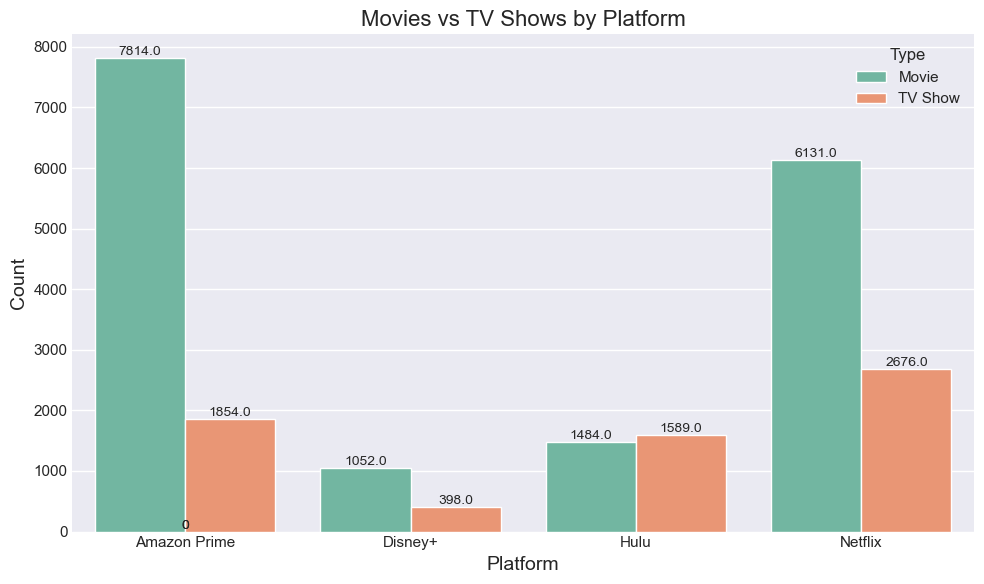

In [47]:

# 7. EDA - Visualizations

# a) Movies vs TV Shows by Platform with counts annotated
plt.figure(figsize=(10,6))
ax = sns.countplot(data=all_data, x='platform', hue='type', palette=palette, hue_order=['Movie', 'TV Show'])
plt.title('Movies vs TV Shows by Platform', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Platform', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)
plt.legend(title='Type')
plt.tight_layout()
plt.show()


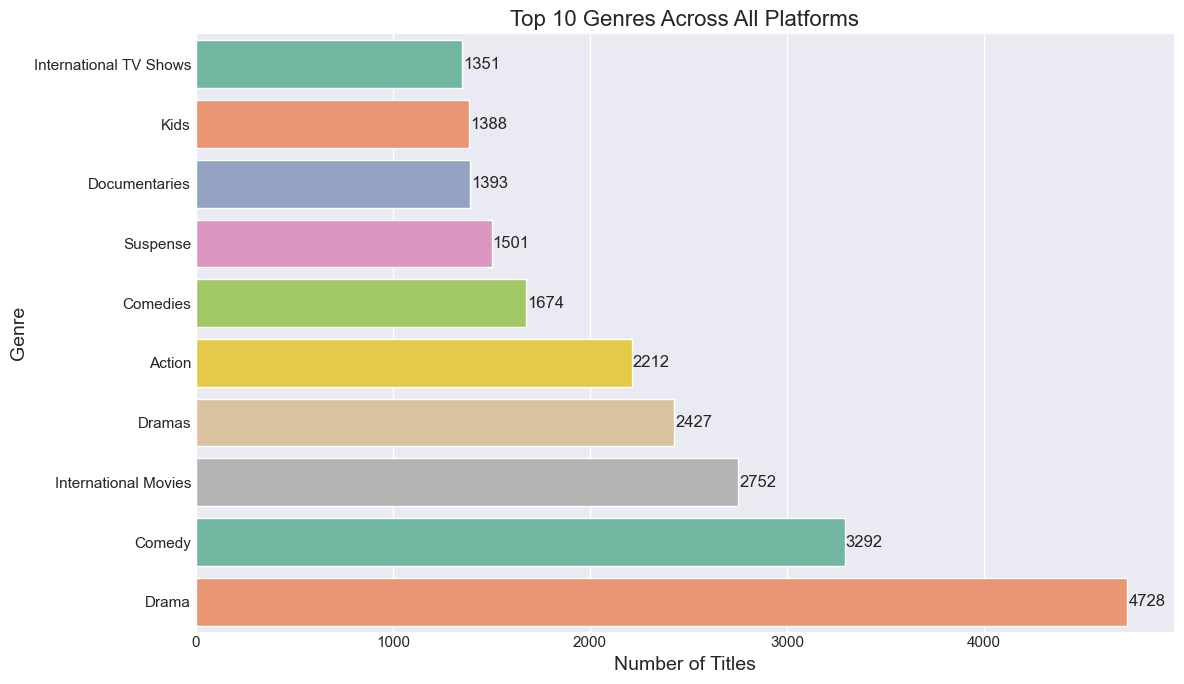

In [48]:
# b) Top 10 Genres Overall - horizontal bars with counts labeled
all_genres = all_data['listed_in'].str.split(', ').explode()
top_genres = all_genres.value_counts().head(10)
top_genres_sorted = top_genres.sort_values()

plt.figure(figsize=(12,7))
sns.barplot(x=top_genres_sorted.values, y=top_genres_sorted.index, palette=palette)
plt.title('Top 10 Genres Across All Platforms', fontsize=16)
plt.xlabel('Number of Titles', fontsize=14)
plt.ylabel('Genre', fontsize=14)
for index, value in enumerate(top_genres_sorted):
    plt.text(value + 5, index, str(value), va='center')
plt.tight_layout()
plt.show()

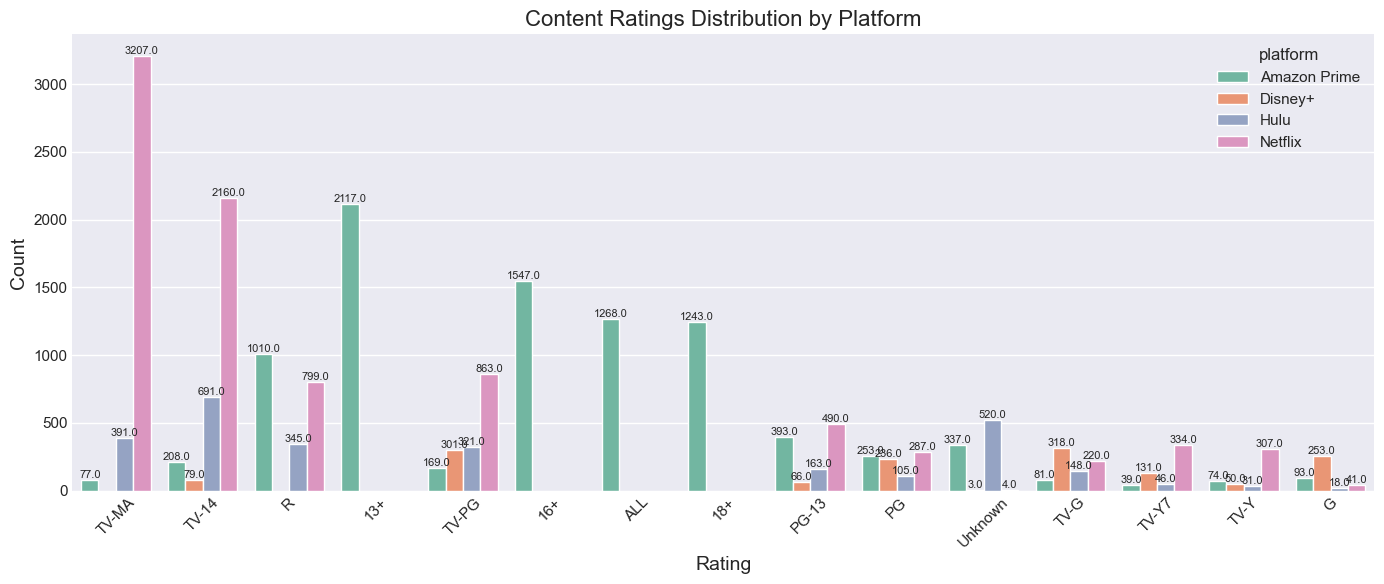

In [50]:
# c) Ratings distribution by platform (top 15 ratings)
top_ratings = all_data['rating'].value_counts().index[:15]

plt.figure(figsize=(14,6))
ax = sns.countplot(data=all_data, x='rating', hue='platform', order=top_ratings, palette=palette)
plt.title('Content Ratings Distribution by Platform', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xlabel('Rating', fontsize=14)
plt.xticks(rotation=45)

# Annotate counts
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


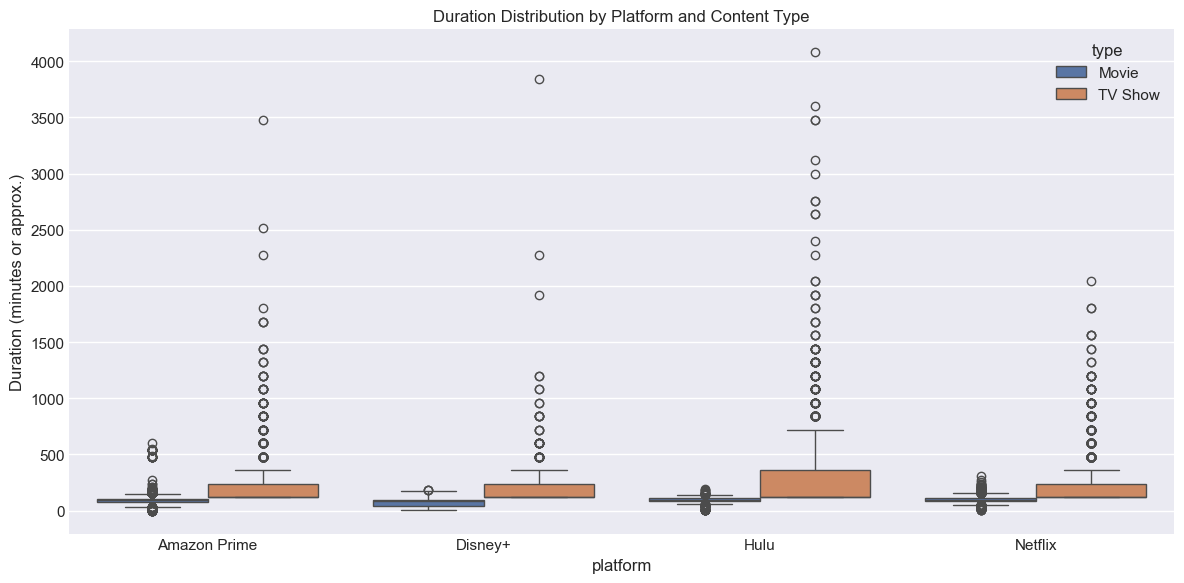

In [51]:

# d) Duration distribution by platform and type
plt.figure(figsize=(12,6))
sns.boxplot(data=all_data, x='platform', y='duration_int', hue='type')
plt.title('Duration Distribution by Platform and Content Type')
plt.ylabel('Duration (minutes or approx.)')
plt.tight_layout()
plt.show()


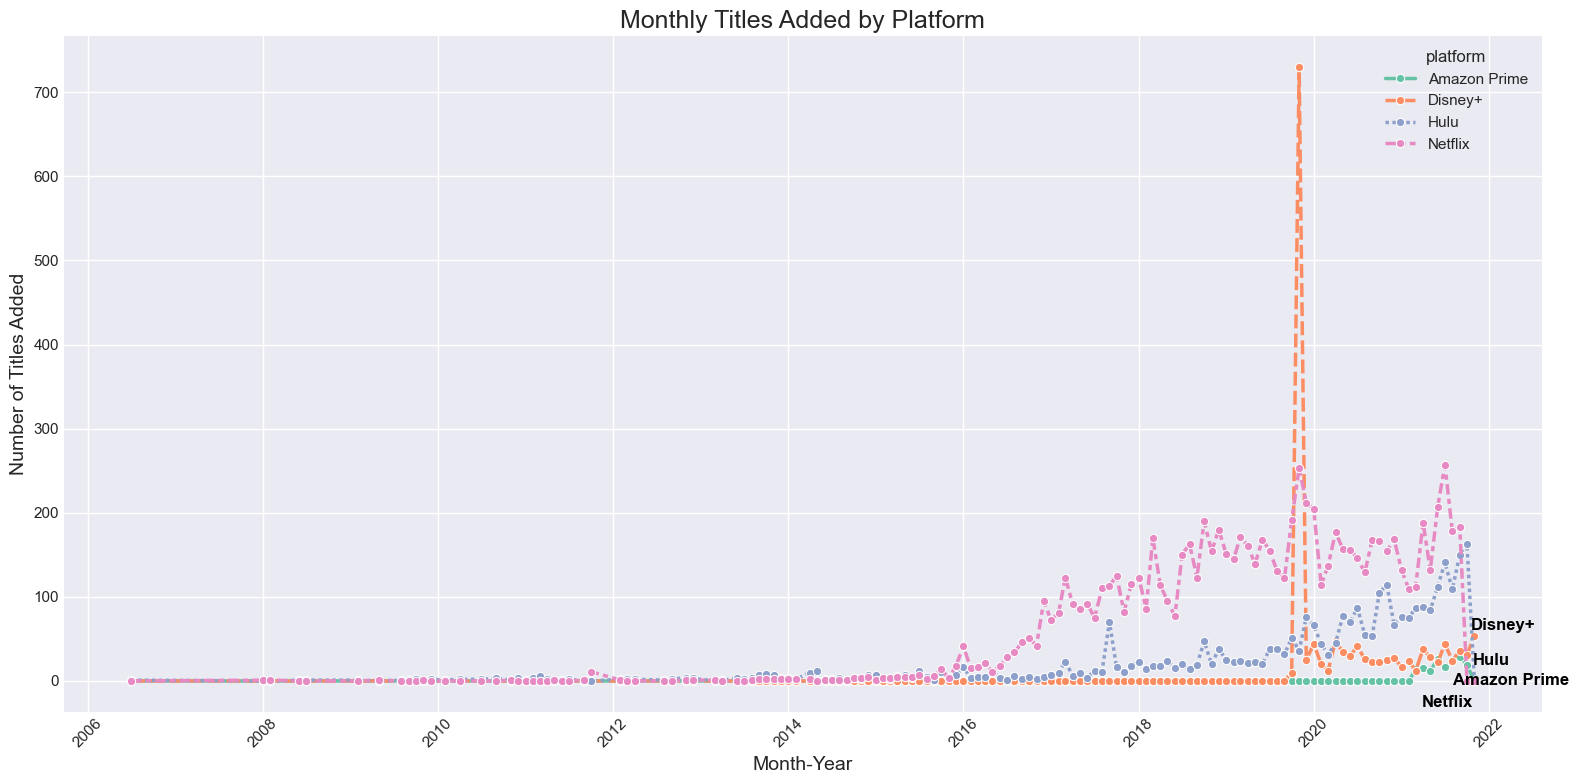

In [52]:
# 8. Time-Series Analysis - Monthly titles added by platform
monthly_counts = all_data.dropna(subset=['date_added'])
monthly_counts = monthly_counts.groupby([monthly_counts['date_added'].dt.to_period('M'), 'platform']).size().unstack(fill_value=0)
monthly_counts.index = monthly_counts.index.to_timestamp()

plt.figure(figsize=(16,8))
sns.lineplot(data=monthly_counts, palette=palette, linewidth=2.5, marker='o')
plt.title('Monthly Titles Added by Platform', fontsize=18)
plt.xlabel('Month-Year', fontsize=14)
plt.ylabel('Number of Titles Added', fontsize=14)

texts = []
for platform in monthly_counts.columns:
    texts.append(
        plt.text(monthly_counts.index[-1], monthly_counts[platform].iloc[-1], platform,
                 horizontalalignment='left', size='medium', color='black', weight='semibold')
    )
from adjustText import adjust_text
adjust_text(texts)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [53]:

# 9. Sentiment Analysis on Titles and Descriptions

def get_sentiment(text):
    try:
        return TextBlob(str(text)).sentiment.polarity
    except:
        return 0

all_data['title_sentiment'] = all_data['title'].apply(get_sentiment)
all_data['desc_sentiment'] = all_data['description'].apply(get_sentiment)

# Optional: Categorize sentiment (uncomment if needed)
# def categorize_sentiment(polarity):
#     if polarity > 0.1:
#         return 'Positive'
#     elif polarity < -0.1:
#         return 'Negative'
#     else:
#         return 'Neutral'
# all_data['desc_sentiment_label'] = all_data['desc_sentiment'].apply(categorize_sentiment)


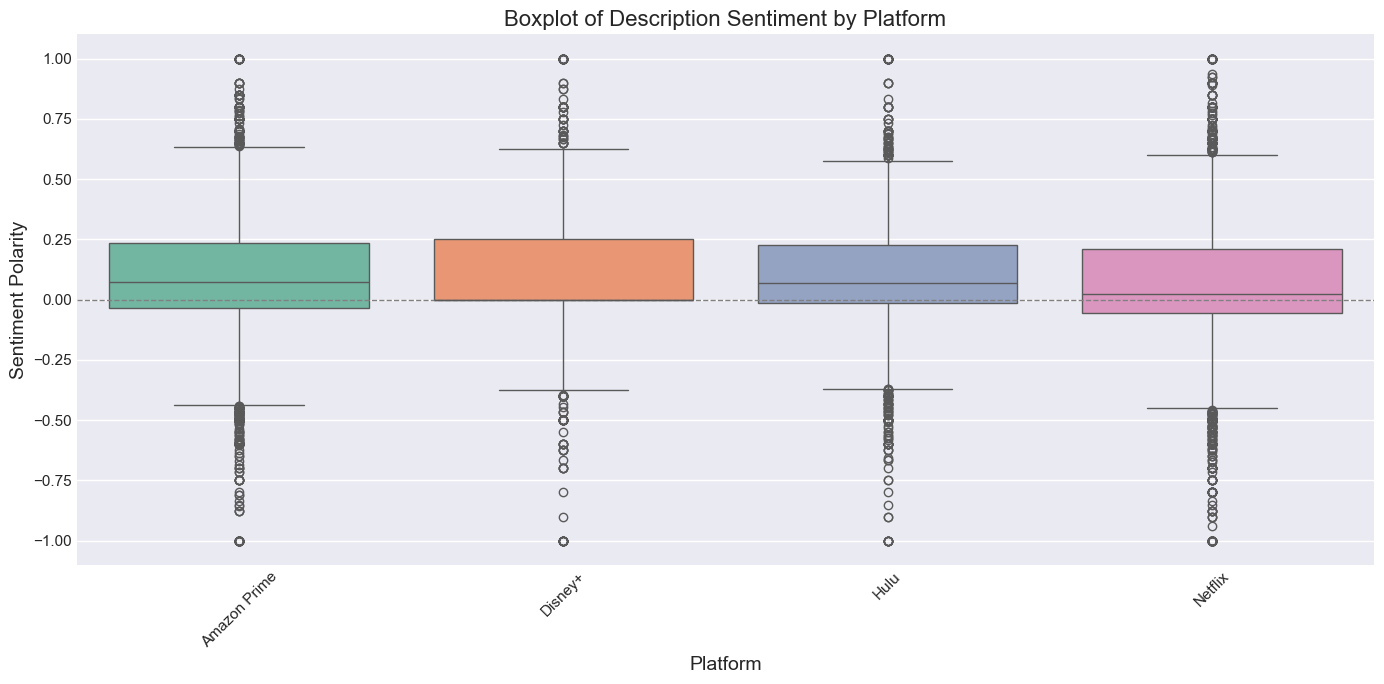

In [54]:
# 1. Boxplot: Shows distribution with quartiles and outliers per platform
plt.figure(figsize=(14,7))
sns.boxplot(data=all_data, x='platform', y='desc_sentiment', palette=palette)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Reference line at neutral sentiment 0
plt.title('Boxplot of Description Sentiment by Platform', fontsize=16)
plt.xlabel('Platform', fontsize=14)
plt.ylabel('Sentiment Polarity', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

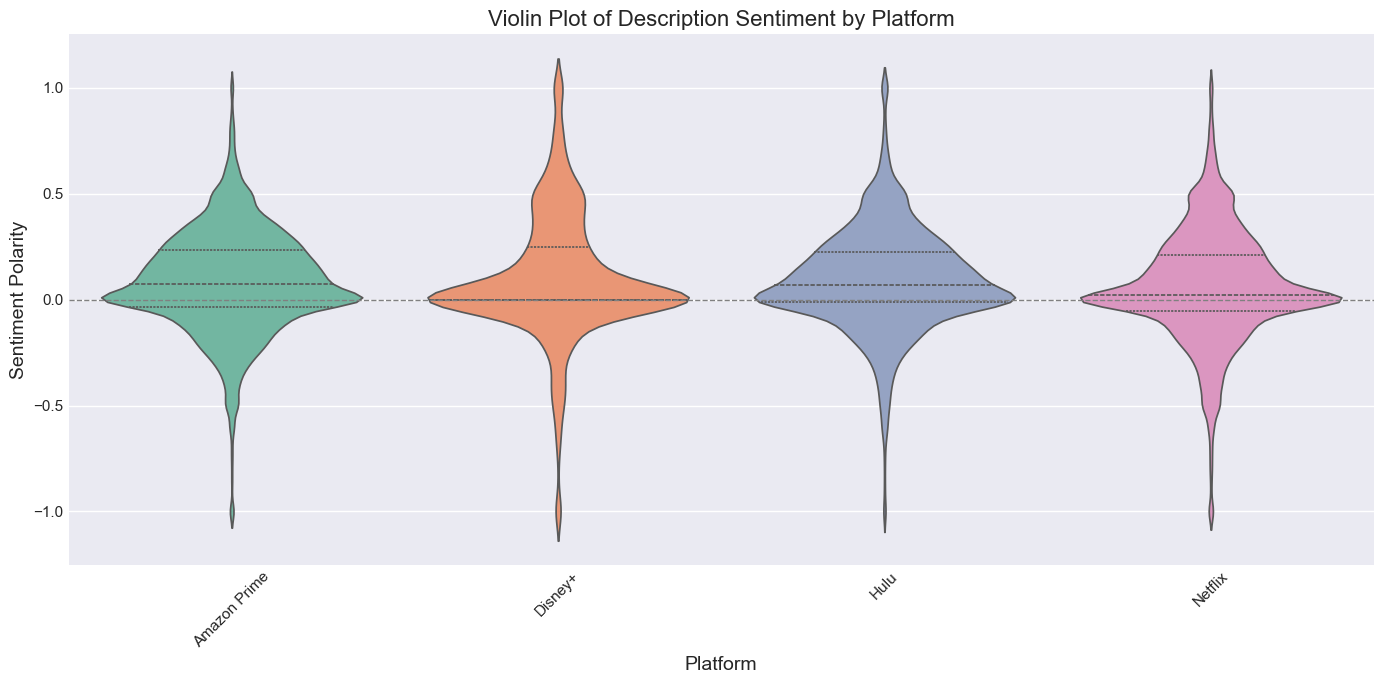

In [55]:
# 2. Violin Plot: Combines KDE and boxplot info showing distribution shape & spread
plt.figure(figsize=(14,7))
sns.violinplot(data=all_data, x='platform', y='desc_sentiment', palette=palette, inner='quartile')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Neutral sentiment line
plt.title('Violin Plot of Description Sentiment by Platform', fontsize=16)
plt.xlabel('Platform', fontsize=14)
plt.ylabel('Sentiment Polarity', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


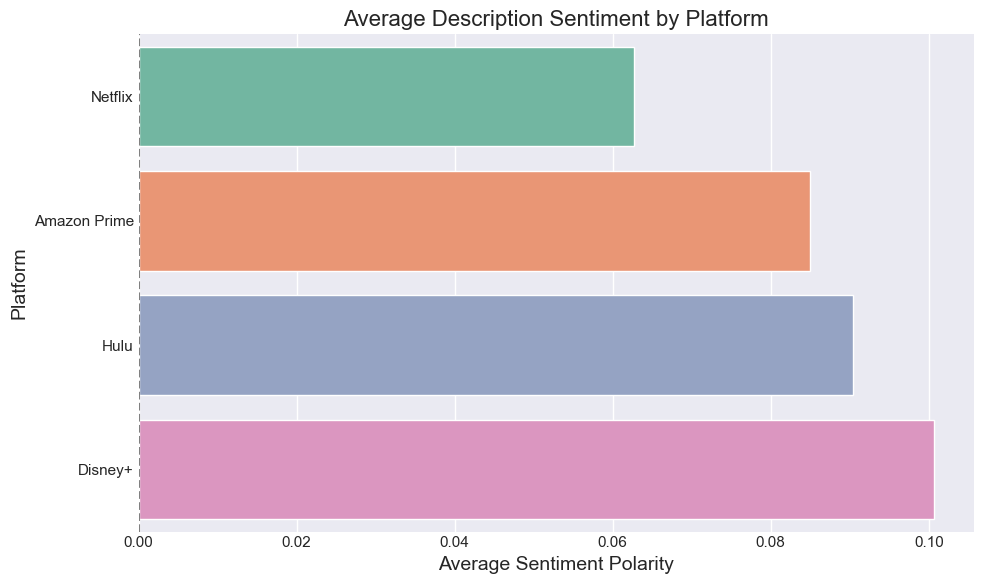

In [56]:
# 3. Barplot: Average sentiment polarity by platform — useful to compare overall positivity/negativity
sentiment_means = all_data.groupby('platform')['desc_sentiment'].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_means.values, y=sentiment_means.index, palette=palette)
plt.axvline(0, color='gray', linestyle='--')  # Neutral sentiment reference line
plt.title('Average Description Sentiment by Platform', fontsize=16)
plt.xlabel('Average Sentiment Polarity', fontsize=14)
plt.ylabel('Platform', fontsize=14)
plt.tight_layout()
plt.show()

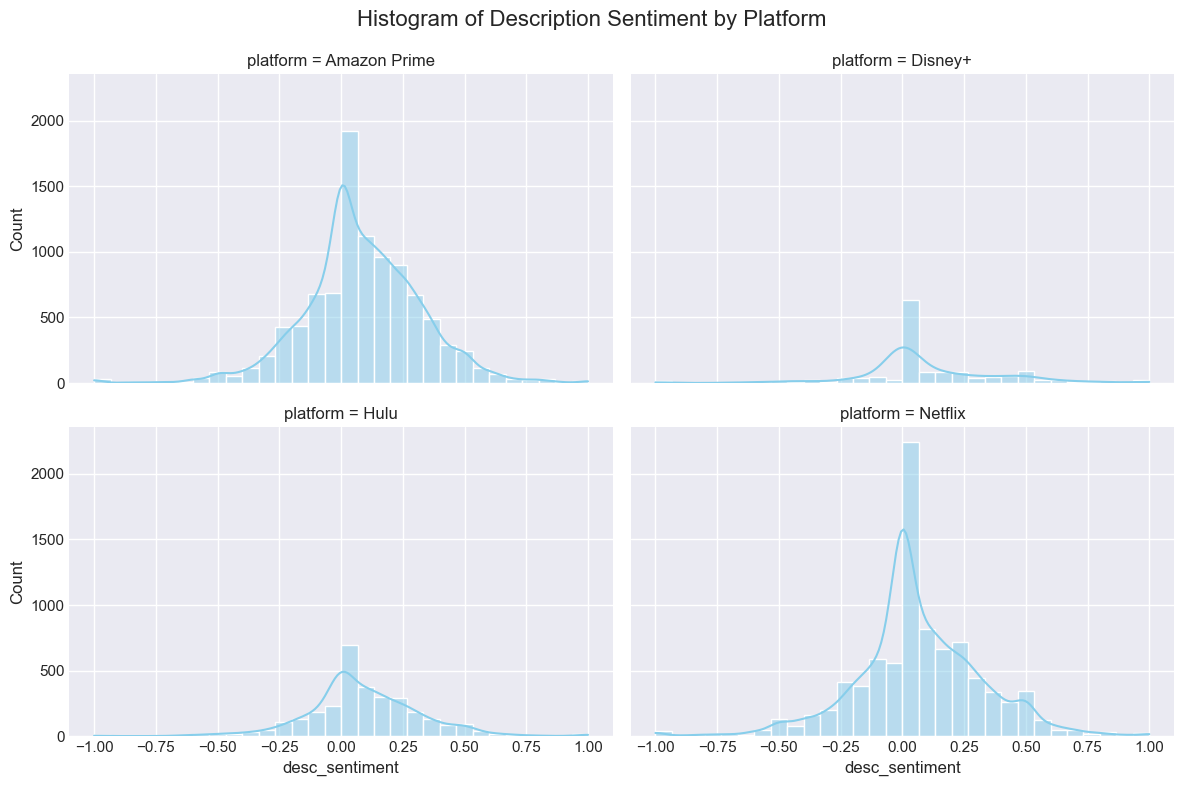

In [57]:
# 4. Histogram + KDE per platform using FacetGrid — good for detailed sentiment distribution view
g = sns.FacetGrid(all_data, col='platform', col_wrap=2, height=4, aspect=1.5)
g.map(sns.histplot, 'desc_sentiment', kde=True, bins=30, color='skyblue')
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Histogram of Description Sentiment by Platform', fontsize=16)
plt.show()


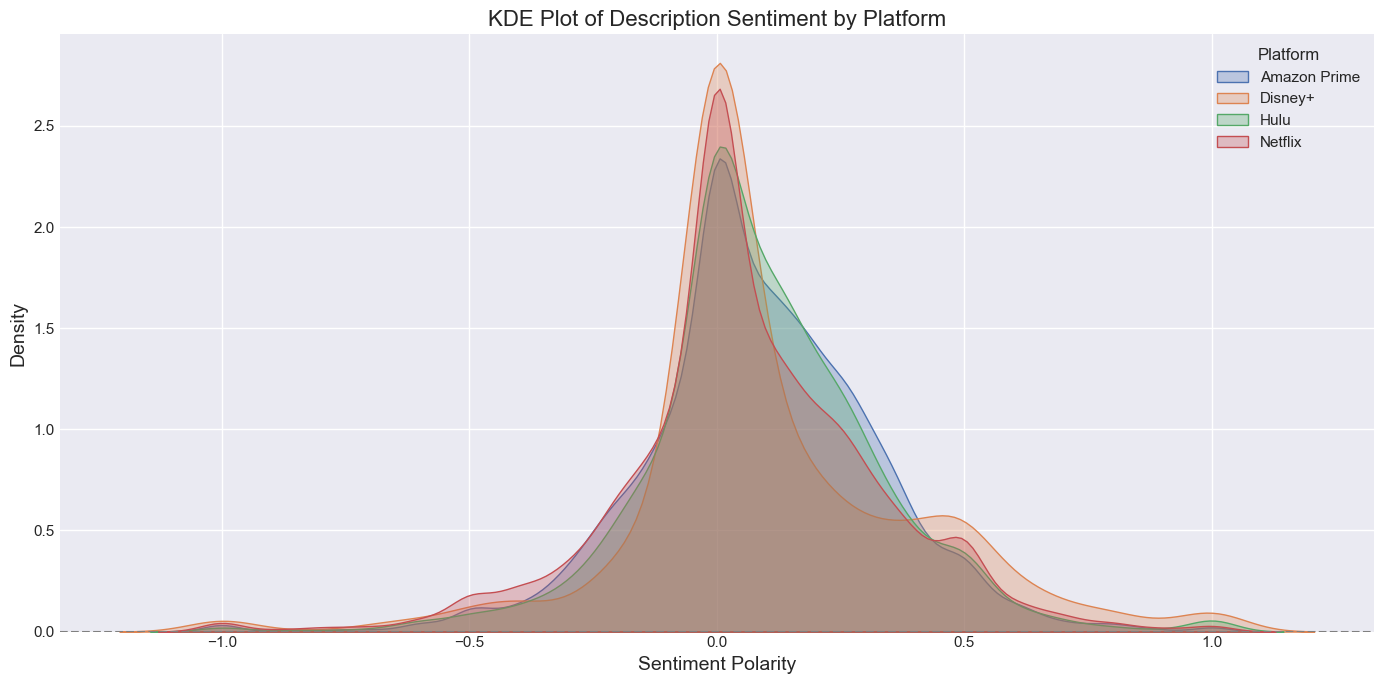

In [58]:
# 5. KDE Plot overlay for all platforms — shows smooth density curves for sentiment polarity distributions
plt.figure(figsize=(14,7))
for platform in all_data['platform'].unique():
    sns.kdeplot(all_data.loc[all_data['platform'] == platform, 'desc_sentiment'], 
                label=platform, fill=True, alpha=0.3)

plt.axhline(0, color='gray', linestyle='--')  # Neutral sentiment line
plt.title('KDE Plot of Description Sentiment by Platform', fontsize=16)
plt.xlabel('Sentiment Polarity', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='Platform')
plt.tight_layout()
plt.show()

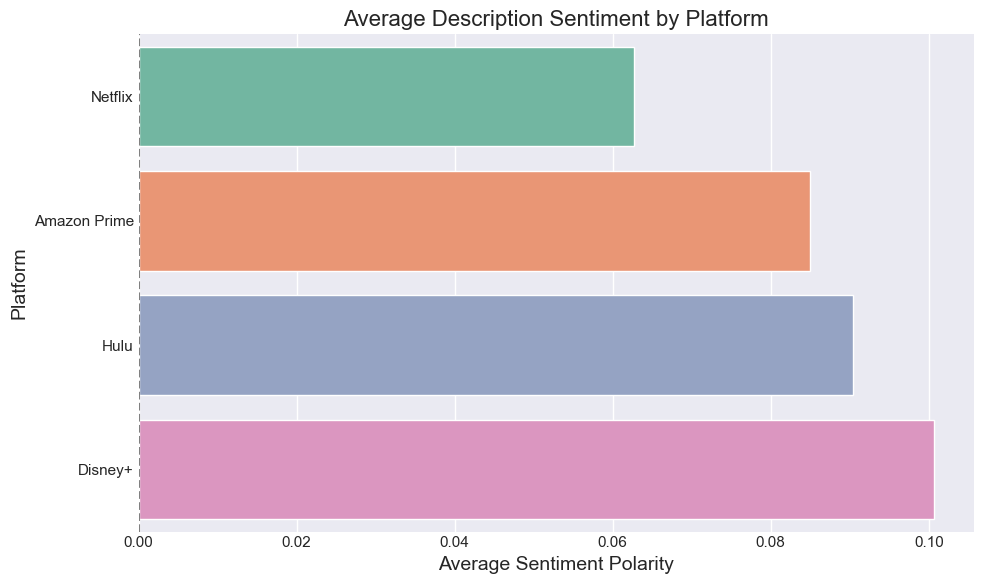

In [59]:
# Mean sentiment barplot per platform
sentiment_means = all_data.groupby('platform')['desc_sentiment'].mean().sort_values()

plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_means.values, y=sentiment_means.index, palette=palette)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Average Description Sentiment by Platform', fontsize=16)
plt.xlabel('Average Sentiment Polarity', fontsize=14)
plt.ylabel('Platform', fontsize=14)
plt.tight_layout()
plt.show()

In [60]:
# 10. Save cleaned and processed data
all_data.to_csv('allstreamingplatforms_cleaned.csv', index=False)
print("Analysis complete. Cleaned data saved as 'allstreaming_platforms_cleaned.csv'")


Analysis complete. Cleaned data saved as 'allstreaming_platforms_cleaned.csv'
